# Bitflipping Environment with DQN (+HER)

### Environment

In [1]:
import numpy as np

class BitFlippingEnv():
    def __init__(self, n:int, seed:int=None):
        if n <= 0:
            raise ValueError("n must be positive integer")
        self.n = n  # number of bits
        if seed is not None:
            self.seed = np.random.seed(seed)
        # action is the bit to flip
        self.action_space = np.arange(n)        
        
    def reset(self):
        self.state = np.random.randint(2, size=self.n)  # random initial state
        self.goal = np.random.randint(2, size=self.n)   # random goal
        
        # goal should be different to initial state
        while np.sum(self.state == self.goal) == self.n:   
            self.goal = np.random.randint(2, size=self.n)
        return self.state, self.goal

    def step(self, state, action):
        # action is the bit to flip
        next_state = np.copy(state)
        next_state[action] = 1 - next_state[action] # flip

        # return next_state, reward, done
        if self.done(next_state, self.goal):
            return next_state, 1, True   
        else:
            return next_state, -1, False
    
    def render(self, state):
        print("State: ", state)
            
    def done(self, state, goal):
        # done if n bits are correct
        return np.sum(state == goal) == self.n

In [2]:
## Testing environment
n = 4
env = BitFlippingEnv(n)

state, goal = env.reset()
print("Initial state:", state, "\t Goal:", goal)
for i in range(1000):
    action = np.random.randint(0,n)
    state, reware, done = env.step(state, action)
    env.render(state)
    if done:
        print("----------------- DONE in ", i+1, "steps")
        break

Initial state: [0 0 0 0] 	 Goal: [0 0 1 1]
State:  [0 0 1 0]
State:  [0 0 1 1]
----------------- DONE in  2 steps


### DQN

In [3]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from dqn_BitflipAgent import Agent

n = 3
env = BitFlippingEnv(n)
agent = Agent(state_size=n, action_size=n, seed=0)

In [5]:
def dqn(n_epoch=200, n_cycles=50, n_episodes=16, eps_start=1.0, eps_end=0.001, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    success = []
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores

    eps = eps_start                    # initialize epsilon
    
    for i_epoch in range(1, n_epoch +1):
        for i_cycle in range(n_cycles):
            state, goal = env.reset()
            score = 0
            
            for i_episode in range(n_episodes*n):                
                state_goal = np.concatenate((state, goal))  # input for agent: s_g

                action = agent.act(state_goal, eps)
                next_state, reward, done = env.step(state, action)

                next_state_goal = np.concatenate((next_state, goal))  # s'_g
                agent.step(state_goal, action, reward, next_state_goal, done)

                state = next_state
                score += reward
                if done:
                    success.append(1)
                    break            
            if not done:
                success.append(0)

            # save most recent score
            scores_window.append(score)       
            scores.append(score)              

            eps = max(eps_end, eps_decay*eps) # decrease epsilon
            
        print('\rEpoch {}\tAverage Score: {:.2f}'.format(i_epoch, np.mean(scores_window)), end="")
        if i_epoch % (n_cycles/5) == 0:
            print('\rEpoch {}\tAverage Score: {:.2f}'.format(i_epoch, np.mean(scores_window)))
   
    return scores, success

scores, success = dqn()


Epoch 10	Average Score: 0.19
Epoch 20	Average Score: 0.41
Epoch 30	Average Score: 0.37
Epoch 40	Average Score: 0.29
Epoch 50	Average Score: 0.39
Epoch 60	Average Score: 0.30
Epoch 70	Average Score: 0.44
Epoch 80	Average Score: 0.29
Epoch 90	Average Score: 0.30
Epoch 100	Average Score: 0.24
Epoch 110	Average Score: 0.35
Epoch 120	Average Score: 0.31
Epoch 130	Average Score: 0.25
Epoch 140	Average Score: 0.39
Epoch 150	Average Score: 0.38
Epoch 160	Average Score: 0.33
Epoch 170	Average Score: 0.33
Epoch 180	Average Score: 0.23
Epoch 190	Average Score: 0.29
Epoch 200	Average Score: 0.29


In [6]:
# save numpy array as csv file
#from numpy import asarray
#from numpy import savetxt
# define data
#data = asarray([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
# save to csv file
#savetxt('data.csv', data, delimiter=',')

# load numpy array from csv file
#from numpy import loadtxt
# load array
#data = loadtxt('data.csv', delimiter=',')
# print the array
#print(data)

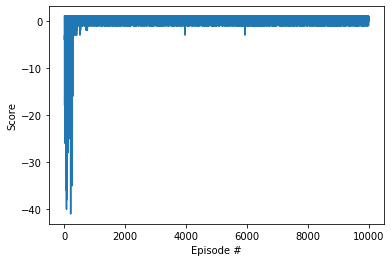

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

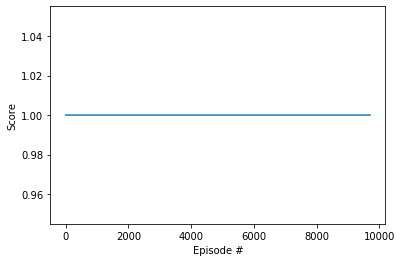

In [8]:
import pandas as pd

# plot success
N = 300
rolling_avg = pd.Series(success).rolling(window = N).mean().iloc[N-1:].values

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(rolling_avg)), rolling_avg)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [9]:
# saving trained network
#torch.save(agent.qnetwork_local.state_dict(), './trained_checkpoints/trained_checkpoint_n8_epo200.pth')

### Testing trained agent on Bitflipping

In [10]:
n = 10
env = BitFlippingEnv(n)
agent = Agent(state_size=n, action_size=n, seed=0)

# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('./trained_checkpoints/trained_checkpoint_n10_epo200.pth'))

s = 0
m = 100
for i in range(m):
    state, goal = env.reset()
    #print("Goal:", goal, "\t Initial state:", state)
    #print("difference: ", n - np.sum(state == goal))
    for j in range(n):
        state_goal = np.concatenate((state, goal))

        action = agent.act(state_goal, 0)
        state, reward, done = env.step(state, action)
        
        if done:
            s += 1
            #print("final state:", state, "steps:", j+1)
            break 
            
print("Success rate {}/{}".format(s,m))

Success rate 100/100


In [11]:
a = scores
b = success

### DQN+HER Implementation

In [27]:
from dqn_BitflipAgent_HER import Agent
n = 48
env = BitFlippingEnv(n)
agent = Agent(state_size=n, action_size=n, seed=0)

In [ ]:
def dqn_HER(n_epoch=200, n_cycles=50, n_episodes=16, eps_start=1.0, eps_end=0.05, eps_decay=0.9995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    success = []
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores

    #eps = eps_start                    # initialize epsilon
    eps = 0.2
    
    for i_epoch in range(1, n_epoch +1):
        for i_cycle in range(n_cycles):
            state, goal = env.reset()
            score = 0

            for i_episode in range(n_episodes*n):                
                state_goal = np.concatenate((state, goal))  # input for agent: s_g
                action = agent.act(state_goal, eps)
                next_state, reward, done = env.step(state, action)
                
                state_her = state  # save state for HER
                state = next_state
                score += reward
                
                next_state_goal = np.concatenate((next_state, goal))  # s'_g
                agent.step(state_goal, action, reward, next_state_goal, done)  # storing and learning                

                if done:
                    success.append(1)
                    break
            if not done:
                success.append(0)
                 # additional goal (virtual)
                goal_her = state  
                state_goal_her = np.concatenate((state_her, goal_her))  # input for agent

                next_state_goal_her = np.concatenate((next_state, goal_her))  # next_state same as state
                
                done_her = True
                reward_her = 1
                agent.step(state_goal_her, action, reward_her, next_state_goal_her, done_her)  # storing and learning from virtual goal

            # save most recent score
            scores_window.append(score)       
            scores.append(score)              

            #eps = max(eps_end, eps_decay*eps) # decrease epsilon
            
            
        print('\rEpoch {}\tAverage Score: {:.2f}'.format(i_epoch, np.mean(scores_window)), end="")
        if i_epoch % (n_cycles/5) == 0:
            print('\rEpoch {}\tAverage Score: {:.2f}'.format(i_epoch, np.mean(scores_window)))
   
    return scores, success
scores, success = dqn_HER()

Epoch 10	Average Score: -768.00
Epoch 20	Average Score: -768.00
Epoch 30	Average Score: -768.00
Epoch 40	Average Score: -768.00
Epoch 50	Average Score: -768.00
Epoch 60	Average Score: -768.00
Epoch 70	Average Score: -768.00
Epoch 80	Average Score: -768.00
Epoch 90	Average Score: -768.00
Epoch 93	Average Score: -768.00

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

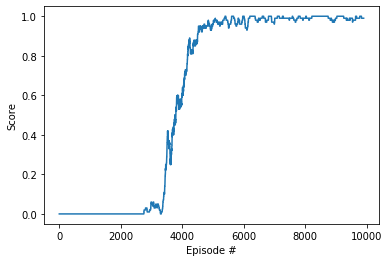

In [17]:
import pandas as pd

# plot success
N = 100
rolling_avg = pd.Series(success).rolling(window = N).mean().iloc[N-1:].values

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(rolling_avg)), rolling_avg)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [18]:
# saving trained network
torch.save(agent.qnetwork_local.state_dict(), './trained_checkpoints/trained_checkpoint_n45_epo200_1.pth')

In [21]:
n = 45
env = BitFlippingEnv(n)
agent = Agent(state_size=n, action_size=n, seed=0)

# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('./trained_checkpoints/trained_checkpoint_n45_epo200_1.pth'))

s = 0
m = 1000
eps = 0

for i in range(m):
    state, goal = env.reset()
    #print("Initial state:", state, "\t Goal:", goal)
    #print("difference: ", n - np.sum(state == goal))
    for j in range(n):
        state_goal = np.concatenate((state, goal))

        action = agent.act(state_goal, eps)
        state, reward, done = env.step(state, action)
        #env.render(state)
        if done:
            s += 1
            #print("done in ", j+1)
            break 
            
print("Success rate {}/{}".format(s,m))

Success rate 843/1000
